In [4]:
import pandas as pd
from models import SingleLayer
from torch.nn import MSELoss
from torch.optim import Adam
import torch
from sklearn import preprocessing
import os

In [5]:
merged_df = pd.read_csv('features/merged_df_PCA.csv')

In [6]:
# 0-1 scaling
# merged_df.iloc[:,1:]=(merged_df.iloc[:,1:]-merged_df.iloc[:,1:].min())/(merged_df.iloc[:,1:].max()-merged_df.iloc[:,1:].min())

In [7]:
# standard scaling
# merged_df.iloc[:,1:]=(merged_df.iloc[:,1:]-merged_df.iloc[:,1:].mean())/merged_df.iloc[:,1:].std()
merged_df.iloc[:,1:-2]=(merged_df.iloc[:,1:-2]-merged_df.iloc[:,1:-2].mean())/merged_df.iloc[:,1:-2].std()

In [8]:
merged_df.head()

,names,Pitch,SpectralCentroid,SpectralSpread,SpectralSkewness,SpectralKurtosis,SpectralFlatness,SpectralCrest,SpectralSlope,SpectralDecrease,...,HarmonicToNoiseEnergy,PartialsToNoiseEnergy,time_s,F1_Hz,F2_Hz,F3_HZ,F4_Hz,F0_Hz,x,y
0,Kazantzidis_a_1,-0.374174,0.343568,0.132063,0.371441,0.119780,-0.211944,-0.080048,-0.007638,-0.264775,...,-0.654803,-1.541246,-0.053264,0.964576,-0.499253,0.446844,0.675132,-0.360590,-6.515803,-6.098293
1,Kazantzidis_a_10,-0.932125,-0.638208,-1.137019,0.867663,0.729608,-0.180965,-0.398441,-0.344094,-0.206485,...,-2.082254,-1.353307,-0.092820,0.632874,-0.559870,0.349565,0.273317,-0.908177,-5.854348,-6.811522
2,Kazantzidis_a_11,0.101629,-0.057072,-1.023722,0.297850,0.266951,-0.216332,-0.814779,0.626441,-0.610205,...,-2.203441,-2.737351,-0.999479,1.115392,-0.339771,0.425181,0.358271,-0.250976,-4.897493,-6.348068
3,Kazantzidis_a_12,-0.644678,0.500753,0.398736,0.058551,-0.199024,-0.216078,-0.893429,0.166494,-0.519946,...,-0.081347,0.204158,1.667119,0.707704,-0.123789,0.364849,0.561908,-0.620741,-6.349987,-5.501987
4,Kazantzidis_a_13,-0.606977,0.378660,-0.015026,-0.338662,-0.514372,-0.216332,-0.438158,0.260989,-0.548315,...,-0.181338,0.188859,0.796104,0.609852,-0.048437,-0.246605,-0.199284,-0.596585,-6.298805,-5.724008


In [9]:
train_x = merged_df.iloc[:,1:-2].values
train_y = merged_df.iloc[:,-2:].values
x = torch.from_numpy(train_x).float()
y = torch.from_numpy(train_y).float()

In [10]:
labels = list(merged_df['names'].str.split('_').str[0])
d = {ni: indi for indi, ni in enumerate(set(labels))}
ids = [d[ni] for ni in labels]

In [11]:
set(labels)

{'Bellou', 'Kazantzidis', 'Ninou', 'Tsaousakis'}

In [12]:
target_x = list(merged_df['x'])
target_y = list(merged_df['y'])

In [13]:
in_dim = train_x.shape[1]
out_dim = train_y.shape[1]
print(in_dim, out_dim)

29 2


In [14]:
model = SingleLayer( in_dim, in_dim, bias=False, orthogonality=True )

In [15]:
loss = MSELoss()
optimizer = Adam( model.parameters(), lr=0.001 )

/Users/max/miniforge3/envs/torchaudio/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
num_epochs = 1000
for epoch in range(num_epochs):
    prediction = model( x.to(model.device) )
    losses = loss(prediction[:,:2], y.to(model.device))
    optimizer.zero_grad()
    losses.backward()
    optimizer.step()
    print(f'Epochs [{epoch+1}/{num_epochs}] - Loss: {losses.item():.4f}', end='\r')

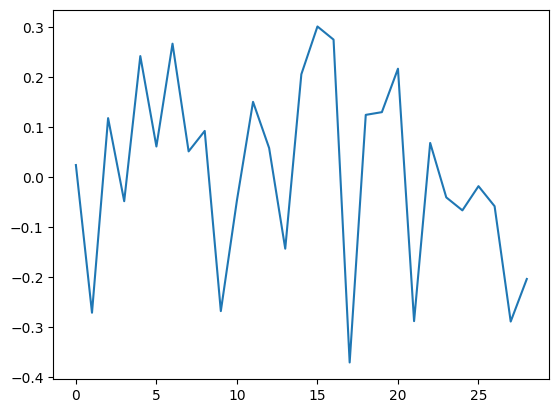

In [17]:
model.visualize_weights()

In [18]:
w = model.linear.weight.cpu().detach().numpy()

In [19]:
# check orthogonality
# w[0,:]@w[1,:].T
w.shape

(29, 29)

In [68]:
proj = train_x@w
print(proj.shape)

(234, 29)


In [20]:
feats_pcs = train_x.T@(proj)

In [75]:
np.corrcoef( proj[:,0] , train_x[:,13] )

array([[ 1.        , -0.53403249],
       [-0.53403249,  1.        ]])

In [21]:
print(feats_pcs[:,0])

[ -87.41238347  -19.69658769  -37.82035203   59.44080326   54.30314886
  -94.7552031   -63.16130144   65.23763701  -87.54421606   21.81158201
   30.33782456  -87.25391064  -66.57652175 -107.58271459  -14.78188475
   85.07352793  -13.55187006   34.96131816  -59.61938894  -43.30387161
   15.78304421  -41.60186646  -17.27793495  100.2735112    53.62062403
  -71.94754069  -79.22442275  -59.11437536  -88.55667447]


In [22]:
import matplotlib.pyplot as plt

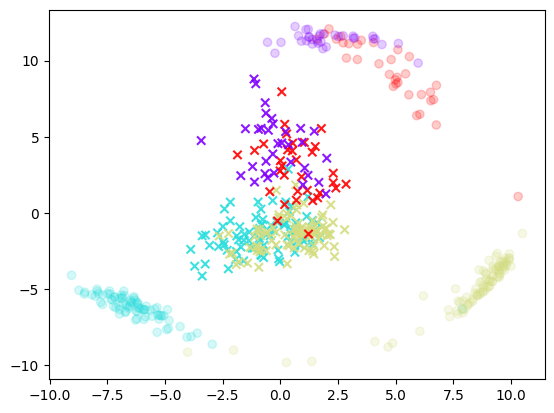

In [23]:
fig, ax = plt.subplots()

scatter = ax.scatter(prediction[:,0].cpu().detach().numpy(), prediction[:,1].cpu().detach().numpy(), marker='x', c=ids, cmap='rainbow', alpha=0.9)
scatter = ax.scatter(target_x, target_y, marker='o', c=ids, cmap='rainbow', alpha=0.2)
# legends = ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
# legends.get_frame().set_alpha(None)
# # legends.get_frame().set_facecolor((0, 0.1, 0.1, 0.1))
# for i,t in enumerate(legends.get_texts()):
#     t.set_text( id2label[str(i)] )
# ax.add_artist(legends)

In [24]:
os.makedirs('figs', exist_ok=True)
fig.savefig('figs/pca_hubert_and_features.png', dpi=300)

In [46]:
from scipy.stats import pearsonr, spearmanr

In [47]:
c0, p0 = pearsonr( prediction[:,0].cpu().detach().numpy(), target_x )
c1, p1 = pearsonr( prediction[:,1].cpu().detach().numpy(), target_y )

In [48]:
print(c0, p0)
print(c1, p1)

0.42544011371465285 1.0539899517061406e-11
0.8667984264209959 4.683650925587869e-72


In [59]:
import hoggorm as ho

In [64]:
rv_results = ho.RVcoeff([ prediction.cpu().detach().numpy(), np.c_[x, y] ])

In [65]:
rv_results

array([[1.        , 0.51118946],
       [0.51118946, 1.        ]])

In [55]:
from sklearn.decomposition import PCA
import numpy as np

In [56]:
values_np = merged_df.iloc[:,1:-2].to_numpy()

In [57]:
pca = PCA(n_components=2)
X_PCA = pca.fit_transform(values_np)
print('explained ratio:', pca.explained_variance_ratio_, ' - total: ', np.sum( pca.explained_variance_ratio_ ))

explained ratio: [0.31244658 0.15320365]  - total:  0.46565022892095687


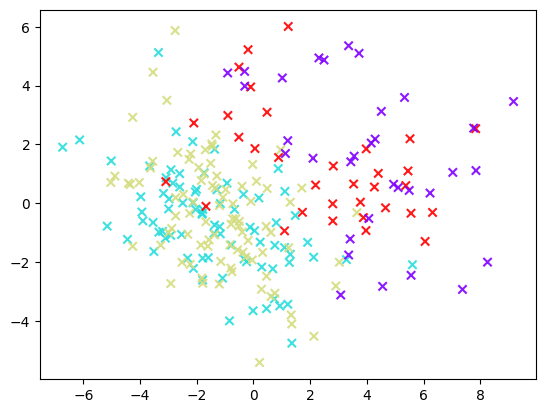

In [28]:
fig, ax = plt.subplots()

scatter = ax.scatter(X_PCA[:,0], X_PCA[:,1], marker='x', c=ids, cmap='rainbow', alpha=0.9)

In [29]:
os.makedirs('figs', exist_ok=True)
fig.savefig('figs/pca_pure_features.png', dpi=300)